In [2]:
!pip install transformers==4.18.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 5.8 MB/s 
     |████████████████████████████████| 880 kB 55.0 MB/s 
     |████████████████████████████████| 163 kB 46.6 MB/s 
     |████████████████████████████████| 6.6 MB 38.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=d66c4be0b356f081019f22bc795239a3b5d5b44e26ebeaf84b21ab72d68501c2
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [3]:
!pip install sentencepiece
!pip install datasets
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 5.4 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 212 kB 43.0 MB/s 
     |████████████████████████████████| 115 kB 59.3 MB/s 
     |████████████████████████████████| 127 kB 60.7 MB/s 
     |████████████████████████████████| 115 kB 57.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import tensorflow as tf
from datasets import Dataset, DatasetDict
from transformers import BartTokenizer, TFBartForConditionalGeneration, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
from rouge_score import rouge_scorer

#importing the data from google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
data=pd.read_csv('/content/drive/MyDrive/PBL Final/test.csv')



In [6]:
checkpoint="facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(checkpoint)
model= TFAutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-cnn.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11490 non-null  object
 1   article     11490 non-null  object
 2   highlights  11490 non-null  object
dtypes: object(3)
memory usage: 269.4+ KB


In [8]:
print("Number of rows in the data:",data.shape[0])

Number of rows in the data: 11490


In [9]:
#checking the data for missing values
data.isna().sum()

id            0
article       0
highlights    0
dtype: int64

In [10]:
#function to remove numbers and punctuations in the data
#removing numbers and punctuations to get exact number of words in the data
def clean_text(text):
  text = text.lower()
  text = re.sub(pattern=r"[^a-zA-Z0-9_\s]",repl="",string=text)
  text = re.sub(pattern=r" {2,10}",repl=" ",string=text)
  return text

In [11]:
cleaned_data=pd.DataFrame()
cleaned_data['article'] = data['article'].apply(clean_text)
cleaned_data['highlights'] = data['highlights'].apply(clean_text)

summary_lengths=[len(summary.split()) for summary in cleaned_data['highlights']]
text_lengths=[len(text.split()) for text in cleaned_data['article']]

Text(0.5, 0.98, 'Distribution of words in summary and original text')

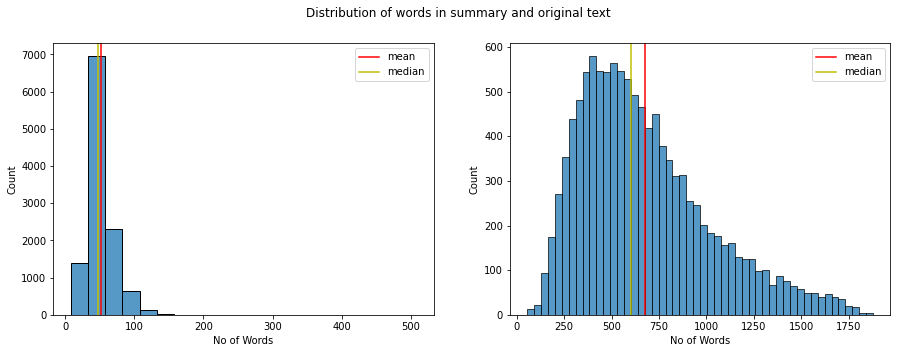

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(summary_lengths,bins=20)
plt.axvline(np.mean(summary_lengths),color="r",label="mean")
plt.axvline(np.median(summary_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.subplot(1,2,2)
sns.histplot(text_lengths,bins=50)
plt.axvline(np.mean(text_lengths),color="r",label="mean")
plt.axvline(np.median(text_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.suptitle("Distribution of words in summary and original text")

In [13]:
print("Average number of words in the summary are:",np.median(summary_lengths))
print("Average number of words in the complete text are:",np.median(text_lengths))

Average number of words in the summary are: 48.0
Average number of words in the complete text are: 605.0


In [14]:
#adding summarize: as prefix for the input sequence
#because the T5 model has been pretrained in the similar fashion for summarization tasks
data['article']=data['article'].apply(lambda x:"summarize: "+x)
data.head(5)

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,summarize: Ever noticed how plane seats appear...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,summarize: A drunk teenage boy had to be rescu...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,summarize: Dougie Freedman is on the verge of ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,summarize: Liverpool target Neto is also wante...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,summarize: Bruce Jenner will break his silence...,"Tell-all interview with the reality TV star, 6..."


In [15]:
#splitting the data into train and validation split in the ratio (85:15)
split = int(len(data)/100*85)
training_data = data[:split]
valid_data = data[split:]

#saving the training and validation split into CSV
training_data.to_csv("news_summarization_training.csv")
valid_data.to_csv("news_summarization_validation.csv")



In [16]:
#importing the dataset into huggingface dataset format for efficient handling and training
train_data = pd.read_csv("news_summarization_training.csv",index_col=None)
valid_data = pd.read_csv("news_summarization_validation.csv",index_col=None)
train = Dataset.from_pandas(train_data[0:200])
valid = Dataset.from_pandas(valid_data[0:50])
dataset=DatasetDict()
dataset['training']=train.remove_columns(['Unnamed: 0'])
dataset['validation']=valid.remove_columns(['Unnamed: 0'])
dataset

DatasetDict({
    training: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 50
    })
})

In [17]:
max_input_length=512
max_target_length=80
def preprocess(example):
  input = tokenizer(example['article'],
                    max_length=max_input_length,
                    truncation=True,
                    )
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(example['highlights'],
                       max_length=max_target_length,
                       truncation=True)
  input['labels']=labels['input_ids']
  return input

In [18]:
tokenized_dataset = dataset.map(preprocess,batched=True)
tokenized_dataset

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    training: Dataset({
        features: ['id', 'article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [19]:
tokenized_dataset.remove_columns(['highlights','article'])

DatasetDict({
    training: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [20]:
datacollator=DataCollatorForSeq2Seq(tokenizer,model=model,return_tensors="tf")

In [21]:


tf_train_dataset = tokenized_dataset['training'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=datacollator,
    shuffle=True,
    batch_size=1
)
tf_train_dataset



<PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [22]:


tf_valid_dataset = tokenized_dataset['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=datacollator,
    shuffle=False,
    batch_size=1)
tf_valid_dataset



<PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [23]:
epochs = 10
#No of training steps are len(dataset)/batch_size*no of epochs
num_train_steps = len(tf_train_dataset) * epochs

#creating a optimizer using transformers create optimizer
optimizer, schedule = create_optimizer(
    init_lr=4e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer) #for loss the model will use the models internal loss by default

# Training in mixed-precision float16 for faster training and efficient memory usage
tf.keras.mixed_precision.set_global_policy("mixed_float16")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [24]:
history = model.fit(tf_train_dataset,validation_data=tf_valid_dataset,epochs=epochs)

Epoch 1/10
200/200 [==============================] - 157s 484ms/step - loss: 1.8335 - val_loss: 1.6441
Epoch 2/10
200/200 [==============================] - 86s 432ms/step - loss: 0.8555 - val_loss: 1.7280
Epoch 3/10
200/200 [==============================] - 87s 436ms/step - loss: 0.4206 - val_loss: 2.0531
Epoch 4/10
200/200 [==============================] - 87s 434ms/step - loss: 0.2221 - val_loss: 2.2826
Epoch 5/10
200/200 [==============================] - 86s 429ms/step - loss: 0.1322 - val_loss: 2.4890
Epoch 6/10
200/200 [==============================] - 89s 445ms/step - loss: 0.0778 - val_loss: 2.5557
Epoch 7/10
200/200 [==============================] - 89s 443ms/step - loss: 0.0566 - val_loss: 2.5962
Epoch 8/10
200/200 [==============================] - 89s 444ms/step - loss: 0.0307 - val_loss: 2.8467
Epoch 9/10
200/200 [==============================] - 89s 446ms/step - loss: 0.0146 - val_loss: 2.9141
Epoch 10/10
200/200 [==============================] - 88s 442ms/step - 

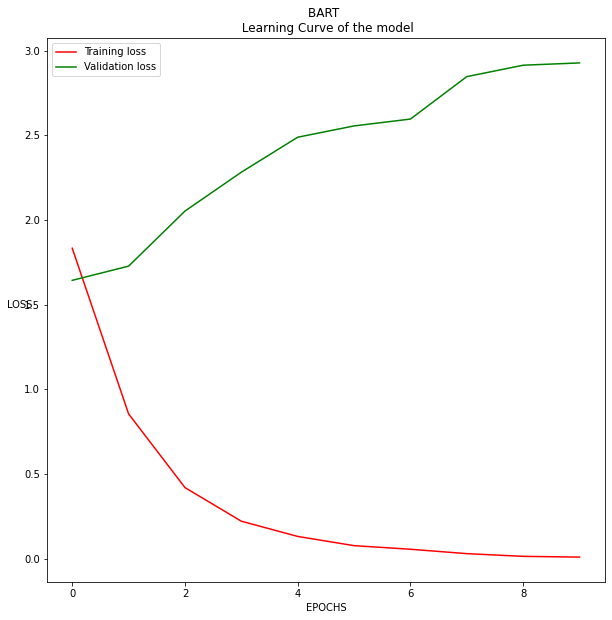

In [25]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],color="red", label="Training loss")
plt.plot(history.history['val_loss'],color="green", label="Validation loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS",rotation=0)
plt.title("BART \n Learning Curve of the model")
plt.legend()

In [26]:
#generating the summaries on the testing dataset
#testing only on the first 100 samples
reference=[]
model_generated=[]
for i,batch in enumerate(tqdm(tf_valid_dataset),start=1):
  if i>101:
    break
  labels=batch['labels'].numpy()
  labels=np.where(labels!=-100,labels,tokenizer.pad_token_id)
  labels=tokenizer.batch_decode(labels,skip_special_tokens=True)
  reference.extend(labels)
  pred=model.generate(**batch,min_length=55,max_length=100)
  pred_decoded = tokenizer.batch_decode(pred,skip_special_tokens=True)
  model_generated.extend(pred_decoded)

100%|██████████| 50/50 [30:21<00:00, 36.44s/it]


In [27]:
def calc_metrics(preds,actual):
  metrics=['rouge1','rouge2','rougeL']
  result={metrics[0]:[],metrics[1]:[],metrics[2]:[]}
  for metric in metrics:
    precision=[]
    recall=[]
    f1=[]
    scorer = rouge_scorer.RougeScorer([metric],use_stemmer=True)
    for x,y in zip(model_generated,reference):
      scores = scorer.score(x,y)
      precision.append(scores[metric][0])
      recall.append(scores[metric][1])
      f1.append(scores[metric][2])
    result[metric].append(np.mean(precision))
    result[metric].append(np.mean(recall))
    result[metric].append(np.mean(f1))
  return pd.DataFrame(result,index=['Precision','Recall','F1-Score'])

In [28]:
scores=calc_metrics(model_generated,reference)
scores

,rouge1,rouge2,rougeL
Precision,0.514276,0.243053,0.355497
Recall,0.398050,0.188638,0.274983
F1-Score,0.442126,0.209188,0.305466


In [29]:
!pip install evaluate
import evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.1 MB/s 


In [30]:
rouge_score = evaluate.load("rouge")

In [31]:
result = rouge_score.compute(
    predictions=pred_decoded, references=labels, use_stemmer=True
)
result

{'rouge1': 0.37606837606837606,
 'rouge2': 0.06956521739130435,
 'rougeL': 0.2905982905982906,
 'rougeLsum': 0.35897435897435903}